In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load cleaned data
df = pd.read_csv('/Users/jakobbullinger/Documents/Coding Projects/DSBA/Intro Machine Learning/kaggle_competition/data/cleaned/df_imputed.csv', index_col=0)

print("="*60)
print("DATA OVERVIEW")
print("="*60)
print(f"Shape: {df.shape}")
print(f"\nTarget distribution:")
print(df['Purchase'].value_counts())
print(df['Purchase'].value_counts(normalize=True))

# Check for issues
print(f"\nMissing values: {df.isnull().sum().sum()}")
print(f"Duplicate rows: {df.duplicated().sum()}")

# Identify columns to drop
cols_to_drop = ['id', 'Session_ID', 'Purchase']
print(f"\nColumns to exclude from features: {[c for c in cols_to_drop if c in df.columns]}")

DATA OVERVIEW
Shape: (13735, 53)

Target distribution:
Purchase
0.0    8679
1.0    5056
Name: count, dtype: int64
Purchase
0.0    0.631889
1.0    0.368111
Name: proportion, dtype: float64

Missing values: 280
Duplicate rows: 0

Columns to exclude from features: ['id', 'Session_ID', 'Purchase']


In [19]:
# Separate features and target
X = df.drop(['Purchase', 'id', 'Session_ID'], axis=1, errors='ignore')
y = df['Purchase']

print("="*60)
print("SPLIT STRATEGY")
print("="*60)
print(f"Total samples: {len(X)}")

# Option A: Simple train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain size: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test size: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")
print(f"\nTrain positive rate: {y_train.mean():.3f}")
print(f"Test positive rate: {y_test.mean():.3f}")

# Check feature types
print(f"\nFeature types in training data:")
print(X_train.dtypes.value_counts())

# Any constant features? (should be none after cleaning)
constant_features = [col for col in X_train.columns if X_train[col].nunique() <= 1]
if constant_features:
    print(f"\n⚠️ Warning: Constant features found: {constant_features}")
else:
    print("\n✅ No constant features")

# Quick check on key features
key_features = ['Items_In_Cart', 'Price', 'Engagement_Score', 'Discount', 'Email_Interaction']
print(f"\nKey features summary (train set):")
print(X_train[key_features].describe())

SPLIT STRATEGY
Total samples: 13735

Train size: 10988 (80.0%)
Test size: 2747 (20.0%)

Train positive rate: 0.368
Test positive rate: 0.368

Feature types in training data:
float64    50
Name: count, dtype: int64

✅ No constant features

Key features summary (train set):
       Items_In_Cart         Price  Engagement_Score      Discount  \
count   10988.000000  10988.000000      10988.000000  10988.000000   
mean        3.523766    564.073234          2.264155     25.152638   
std         2.830891    764.607485          1.434610     14.844076   
min         0.000000      5.127000          0.000000      0.000000   
25%         1.000000    263.817000          1.092159     13.000000   
50%         3.000000    498.216200          2.109863     25.000000   
75%         5.000000    741.811750          3.301331     37.000000   
max        28.000000  14653.463005          6.398595     90.000000   

       Email_Interaction  
count       10988.000000  
mean            0.454201  
std            

In [20]:
print("="*60)
print("BASELINE XGBOOST MODEL")
print("="*60)

# Calculate scale_pos_weight for imbalanced data
# This helps XGBoost handle the 63% negative / 37% positive split
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Class imbalance ratio: {scale_pos_weight:.2f}")
print(f"Using scale_pos_weight={scale_pos_weight:.2f} to handle imbalance\n")

# Baseline XGBoost with reasonable defaults
baseline_xgb = XGBClassifier(
    n_estimators=100,          # Start moderate
    max_depth=6,               # Prevent overfitting
    learning_rate=0.1,         # Standard rate
    scale_pos_weight=scale_pos_weight,  # Handle imbalance
    random_state=42,
    eval_metric='logloss',
    early_stopping_rounds=10   # Stop if no improvement
)

# Train with validation set for early stopping
baseline_xgb.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

# Predictions
y_pred_proba = baseline_xgb.predict_proba(X_test)[:, 1]

# Find optimal F1 threshold
best_f1 = 0
best_threshold = 0.5
thresholds_tested = np.arange(0.1, 0.9, 0.01)

for threshold in thresholds_tested:
    y_pred = (y_pred_proba >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

# Final predictions with optimal threshold
y_pred_optimal = (y_pred_proba >= best_threshold).astype(int)

# Calculate metrics
auc = roc_auc_score(y_test, y_pred_proba)

print("PERFORMANCE METRICS")
print("-" * 60)
print(f"AUC Score: {auc:.4f}")
print(f"Best F1 Score: {best_f1:.4f} (at threshold {best_threshold:.2f})")
print(f"\nClassification Report (at optimal F1 threshold):")
print(classification_report(y_test, y_pred_optimal, digits=3))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_optimal)
print(f"\nConfusion Matrix:")
print(cm)
print(f"  True Negatives:  {cm[0,0]}")
print(f"  False Positives: {cm[0,1]}")
print(f"  False Negatives: {cm[1,0]}")
print(f"  True Positives:  {cm[1,1]}")

# Training vs test performance (check for overfitting)
y_train_pred_proba = baseline_xgb.predict_proba(X_train)[:, 1]
auc_train = roc_auc_score(y_train, y_train_pred_proba)

print(f"\nOverfitting check:")
print(f"  Train AUC: {auc_train:.4f}")
print(f"  Test AUC:  {auc:.4f}")
print(f"  Gap:       {auc_train - auc:.4f}")
if auc_train - auc > 0.05:
    print("  ⚠️ Possible overfitting detected")
else:
    print("  ✅ Model generalizes well")

BASELINE XGBOOST MODEL
Class imbalance ratio: 1.72
Using scale_pos_weight=1.72 to handle imbalance

PERFORMANCE METRICS
------------------------------------------------------------
AUC Score: 0.9376
Best F1 Score: 0.8185 (at threshold 0.49)

Classification Report (at optimal F1 threshold):
              precision    recall  f1-score   support

         0.0      0.930     0.832     0.878      1736
         1.0      0.756     0.892     0.819      1011

    accuracy                          0.854      2747
   macro avg      0.843     0.862     0.848      2747
weighted avg      0.866     0.854     0.856      2747


Confusion Matrix:
[[1445  291]
 [ 109  902]]
  True Negatives:  1445
  False Positives: 291
  False Negatives: 109
  True Positives:  902

Overfitting check:
  Train AUC: 0.9797
  Test AUC:  0.9376
  Gap:       0.0421
  ✅ Model generalizes well



FEATURE IMPORTANCE ANALYSIS

Top 20 Most Important Features:
                  feature  importance
            Items_In_Cart    0.257421
    Campaign_Period_false    0.047853
       Device_Type_mobile    0.043254
        Email_Interaction    0.043155
                    Price    0.034981
                 Category    0.033468
             Reviews_Read    0.033280
         Engagement_Score    0.028674
       Device_Type_tablet    0.021972
      Device_Type_desktop    0.015661
   PM_RS_Combo_bank:email    0.015275
  PM_RS_Combo_cash:direct    0.014678
               Price_Sine    0.014484
    Referral_Source_email    0.014479
PM_RS_Combo_paypal:direct    0.014200
   PM_RS_Combo_paypal:ads    0.014156
  PM_RS_Combo_bank:direct    0.014082
     PM_RS_Combo_cash:ads    0.013712
                      Day    0.013476
      Payment_Method_cash    0.013001


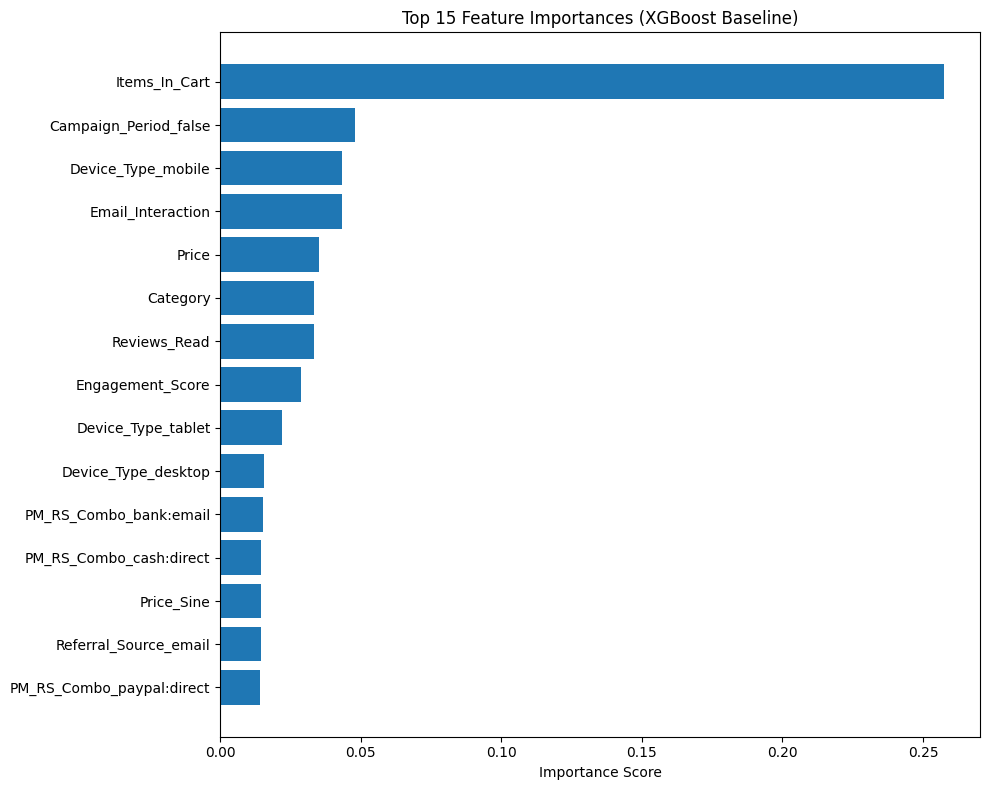


Importance concentration:
  Top 10 features explain: 56.0% of importance
  Total features: 50
  Features with zero importance: 1
    They are: ['Campaign_Period_true']


In [21]:
print("\n" + "="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': baseline_xgb.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance.head(20).to_string(index=False))

# Visualize top 15
plt.figure(figsize=(10, 8))
top_15 = feature_importance.head(15)
plt.barh(range(len(top_15)), top_15['importance'])
plt.yticks(range(len(top_15)), top_15['feature'])
plt.xlabel('Importance Score')
plt.title('Top 15 Feature Importances (XGBoost Baseline)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('xgb_baseline_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Analyze importance concentration
total_importance = feature_importance['importance'].sum()
top_10_importance = feature_importance.head(10)['importance'].sum()
print(f"\nImportance concentration:")
print(f"  Top 10 features explain: {top_10_importance/total_importance*100:.1f}% of importance")
print(f"  Total features: {len(feature_importance)}")

# Check if any features have zero importance (could be dropped)
zero_importance = feature_importance[feature_importance['importance'] == 0]
print(f"  Features with zero importance: {len(zero_importance)}")
if len(zero_importance) > 0 and len(zero_importance) < 20:
    print(f"    They are: {zero_importance['feature'].tolist()}")

PHASE 1: DATA PREPARATION & FEATURE CLEANUP
Initial shape: (13735, 50)
After cleanup: (13735, 49)
Dropped 1 redundant features: ['Campaign_Period_true']

Train size: 10988 (80.0%)
Test size: 2747 (20.0%)
Train positive rate: 0.368
Test positive rate: 0.368

Class imbalance ratio (scale_pos_weight): 1.72

PHASE 2: BASELINE XGBOOST (WITH CLEANED FEATURES)

BASELINE PERFORMANCE:
----------------------------------------------------------------------
Test AUC:  0.9374
Train AUC: 0.9807
Gap:       0.0433
Best F1:   0.8193 (at threshold 0.50)

Classification Report:
              precision    recall  f1-score   support

         0.0      0.928     0.837     0.880      1736
         1.0      0.760     0.888     0.819      1011

    accuracy                          0.856      2747
   macro avg      0.844     0.863     0.850      2747
weighted avg      0.866     0.856     0.858      2747


PHASE 3: REGULARIZED XGBOOST

REGULARIZED PERFORMANCE:
---------------------------------------------------

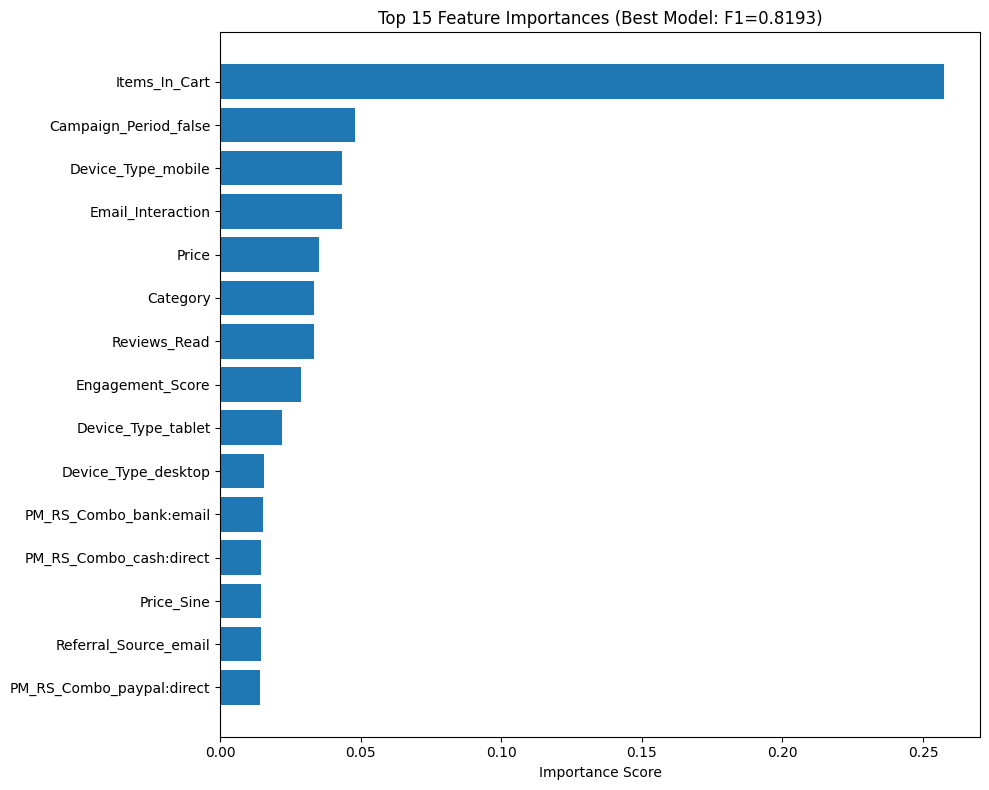


PHASE 6: CONFUSION MATRIX & ERROR ANALYSIS

Confusion Matrix (at threshold 0.50):
[[1453  283]
 [ 113  898]]

  True Negatives:   1453 (correctly predicted non-purchasers)
  False Positives:   283 (predicted purchase, but didn't buy)
  False Negatives:   113 (predicted no purchase, but bought)
  True Positives:    898 (correctly predicted purchasers)

  False Positive Rate: 0.163 (283/1736)
  False Negative Rate: 0.112 (113/1011)

📊 BUSINESS INTERPRETATION:
  - We would target 1181 users
  - Of these, 898 would actually purchase (precision: 0.760)
  - We'd miss 113 potential purchasers


In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("="*70)
print("PHASE 1: DATA PREPARATION & FEATURE CLEANUP")
print("="*70)

# Load cleaned data
df = pd.read_csv('/Users/jakobbullinger/Documents/Coding Projects/DSBA/Intro Machine Learning/kaggle_competition/data/cleaned/df_imputed.csv', index_col=0)

# Separate features and target
X = df.drop(['Purchase', 'id', 'Session_ID'], axis=1, errors='ignore')
y = df['Purchase']

print(f"Initial shape: {X.shape}")

# ============================================================================
# FEATURE CLEANUP: Remove redundant one-hot encoded features
# ============================================================================
# For binary one-hot encoded variables, we only need one column
# (the other is perfectly redundant)

features_to_drop = [
    'Campaign_Period_true',  # Keep Campaign_Period_false only
]

# Drop redundant features
X_clean = X.drop(columns=features_to_drop, errors='ignore')

print(f"After cleanup: {X_clean.shape}")
print(f"Dropped {len(features_to_drop)} redundant features: {features_to_drop}")

# ============================================================================
# TRAIN/TEST SPLIT
# ============================================================================
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain size: {len(X_train)} ({len(X_train)/len(X_clean)*100:.1f}%)")
print(f"Test size: {len(X_test)} ({len(X_test)/len(X_clean)*100:.1f}%)")
print(f"Train positive rate: {y_train.mean():.3f}")
print(f"Test positive rate: {y_test.mean():.3f}")

# Calculate scale_pos_weight for class imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"\nClass imbalance ratio (scale_pos_weight): {scale_pos_weight:.2f}")


# ============================================================================
# PHASE 2: BASELINE MODEL (WITH CLEANED FEATURES)
# ============================================================================
print("\n" + "="*70)
print("PHASE 2: BASELINE XGBOOST (WITH CLEANED FEATURES)")
print("="*70)

baseline_xgb = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss'
)

# Train
baseline_xgb.fit(X_train, y_train)

# Predictions
y_pred_proba_baseline = baseline_xgb.predict_proba(X_test)[:, 1]
y_train_pred_proba_baseline = baseline_xgb.predict_proba(X_train)[:, 1]

# Find optimal F1 threshold
best_f1_baseline = 0
best_threshold_baseline = 0.5

for threshold in np.arange(0.1, 0.9, 0.01):
    y_pred = (y_pred_proba_baseline >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred)
    if f1 > best_f1_baseline:
        best_f1_baseline = f1
        best_threshold_baseline = threshold

y_pred_optimal_baseline = (y_pred_proba_baseline >= best_threshold_baseline).astype(int)

# Metrics
auc_baseline = roc_auc_score(y_test, y_pred_proba_baseline)
auc_train_baseline = roc_auc_score(y_train, y_train_pred_proba_baseline)

print("\nBASELINE PERFORMANCE:")
print("-" * 70)
print(f"Test AUC:  {auc_baseline:.4f}")
print(f"Train AUC: {auc_train_baseline:.4f}")
print(f"Gap:       {auc_train_baseline - auc_baseline:.4f}")
print(f"Best F1:   {best_f1_baseline:.4f} (at threshold {best_threshold_baseline:.2f})")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_optimal_baseline, digits=3))


# ============================================================================
# PHASE 3: REGULARIZED MODEL (REDUCE OVERFITTING)
# ============================================================================
print("\n" + "="*70)
print("PHASE 3: REGULARIZED XGBOOST")
print("="*70)

regularized_xgb = XGBClassifier(
    n_estimators=100,
    max_depth=5,              # Reduced from 6
    learning_rate=0.1,
    min_child_weight=3,       # More regularization (default=1)
    gamma=0.1,                # Minimum loss reduction for split (default=0)
    subsample=0.8,            # Use 80% of training data per tree
    colsample_bytree=0.8,     # Use 80% of features per tree
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss'
)

# Train
regularized_xgb.fit(X_train, y_train)

# Predictions
y_pred_proba_reg = regularized_xgb.predict_proba(X_test)[:, 1]
y_train_pred_proba_reg = regularized_xgb.predict_proba(X_train)[:, 1]

# Find optimal F1 threshold
best_f1_reg = 0
best_threshold_reg = 0.5

for threshold in np.arange(0.1, 0.9, 0.01):
    y_pred = (y_pred_proba_reg >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred)
    if f1 > best_f1_reg:
        best_f1_reg = f1
        best_threshold_reg = threshold

y_pred_optimal_reg = (y_pred_proba_reg >= best_threshold_reg).astype(int)

# Metrics
auc_reg = roc_auc_score(y_test, y_pred_proba_reg)
auc_train_reg = roc_auc_score(y_train, y_train_pred_proba_reg)

print("\nREGULARIZED PERFORMANCE:")
print("-" * 70)
print(f"Test AUC:  {auc_reg:.4f}")
print(f"Train AUC: {auc_train_reg:.4f}")
print(f"Gap:       {auc_train_reg - auc_reg:.4f}")
print(f"Best F1:   {best_f1_reg:.4f} (at threshold {best_threshold_reg:.2f})")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_optimal_reg, digits=3))


# ============================================================================
# PHASE 4: COMPARISON
# ============================================================================
print("\n" + "="*70)
print("PHASE 4: MODEL COMPARISON")
print("="*70)

comparison = pd.DataFrame({
    'Model': ['Baseline', 'Regularized'],
    'Test_AUC': [auc_baseline, auc_reg],
    'Train_AUC': [auc_train_baseline, auc_train_reg],
    'AUC_Gap': [auc_train_baseline - auc_baseline, auc_train_reg - auc_reg],
    'F1_Score': [best_f1_baseline, best_f1_reg],
    'Threshold': [best_threshold_baseline, best_threshold_reg]
})

print("\n", comparison.to_string(index=False))

# Determine winner
if best_f1_reg > best_f1_baseline:
    print(f"\n✅ REGULARIZED MODEL WINS!")
    print(f"   F1 improvement: +{best_f1_reg - best_f1_baseline:.4f}")
    print(f"   Overfitting reduced: {(auc_train_baseline - auc_baseline) - (auc_train_reg - auc_reg):.4f}")
    best_model = regularized_xgb
    best_f1 = best_f1_reg
    best_threshold = best_threshold_reg
    y_pred_proba_best = y_pred_proba_reg
else:
    print(f"\n✅ BASELINE MODEL WINS!")
    print(f"   F1 difference: {best_f1_baseline - best_f1_reg:.4f}")
    best_model = baseline_xgb
    best_f1 = best_f1_baseline
    best_threshold = best_threshold_baseline
    y_pred_proba_best = y_pred_proba_baseline


# ============================================================================
# PHASE 5: FEATURE IMPORTANCE (BEST MODEL)
# ============================================================================
print("\n" + "="*70)
print("PHASE 5: FEATURE IMPORTANCE ANALYSIS (BEST MODEL)")
print("="*70)

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance.head(20).to_string(index=False))

# Check concentration
total_importance = feature_importance['importance'].sum()
top_10_importance = feature_importance.head(10)['importance'].sum()
print(f"\nTop 10 features explain: {top_10_importance/total_importance*100:.1f}% of importance")

# Zero importance features
zero_importance = feature_importance[feature_importance['importance'] == 0]
print(f"Features with zero importance: {len(zero_importance)}")
if len(zero_importance) > 0 and len(zero_importance) < 10:
    print(f"  They are: {zero_importance['feature'].tolist()}")

# Visualize
plt.figure(figsize=(10, 8))
top_15 = feature_importance.head(15)
plt.barh(range(len(top_15)), top_15['importance'])
plt.yticks(range(len(top_15)), top_15['feature'])
plt.xlabel('Importance Score')
plt.title(f'Top 15 Feature Importances (Best Model: F1={best_f1:.4f})')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('best_model_feature_importance.png', dpi=300, bbox_inches='tight')
print("\n✅ Saved feature importance plot: best_model_feature_importance.png")
plt.show()


# ============================================================================
# PHASE 6: CONFUSION MATRIX ANALYSIS
# ============================================================================
print("\n" + "="*70)
print("PHASE 6: CONFUSION MATRIX & ERROR ANALYSIS")
print("="*70)

y_pred_best = (y_pred_proba_best >= best_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred_best)

print(f"\nConfusion Matrix (at threshold {best_threshold:.2f}):")
print(cm)
print(f"\n  True Negatives:  {cm[0,0]:>5} (correctly predicted non-purchasers)")
print(f"  False Positives: {cm[0,1]:>5} (predicted purchase, but didn't buy)")
print(f"  False Negatives: {cm[1,0]:>5} (predicted no purchase, but bought)")
print(f"  True Positives:  {cm[1,1]:>5} (correctly predicted purchasers)")

# Calculate rates
total_negative = cm[0,0] + cm[0,1]
total_positive = cm[1,0] + cm[1,1]
fpr = cm[0,1] / total_negative  # False Positive Rate
fnr = cm[1,0] / total_positive  # False Negative Rate

print(f"\n  False Positive Rate: {fpr:.3f} ({cm[0,1]}/{total_negative})")
print(f"  False Negative Rate: {fnr:.3f} ({cm[1,0]}/{total_positive})")

# Business interpretation
print("\n📊 BUSINESS INTERPRETATION:")
print(f"  - We would target {cm[0,1] + cm[1,1]} users")
print(f"  - Of these, {cm[1,1]} would actually purchase (precision: {cm[1,1]/(cm[0,1] + cm[1,1]):.3f})")
print(f"  - We'd miss {cm[1,0]} potential purchasers")


# ============================================================================
# SAVE RESULTS
# =====


BUDGET OPTIMIZATION ANALYSIS (CORRECTED)

  Threshold  Users_Targeted Cost_EUR  Expected_Purchases Expected_Revenue    ROI Precision Recall F1_Score
      0.30            1417   141.70                 969         48450.00 340.92     0.684  0.958   0.7982
      0.35            1350   135.00                 953         47650.00 351.96     0.706  0.943   0.8073
      0.40            1297   129.70                 938         46900.00 360.60     0.723  0.928   0.8128
      0.45            1231   123.10                 912         45600.00 369.43     0.741  0.902   0.8136
      0.50            1181   118.10                 898         44900.00 379.19     0.760  0.888   0.8193
      0.55            1117   111.70                 858         42900.00 383.06     0.768  0.849   0.8064
      0.60            1037   103.70                 815         40750.00 391.96     0.786  0.806   0.7959

📊 Budget Constraint: €200 (max 2000 users)

🎯 STRATEGY 1: Maximize Total Purchases
  Threshold: 0.3
  Targe

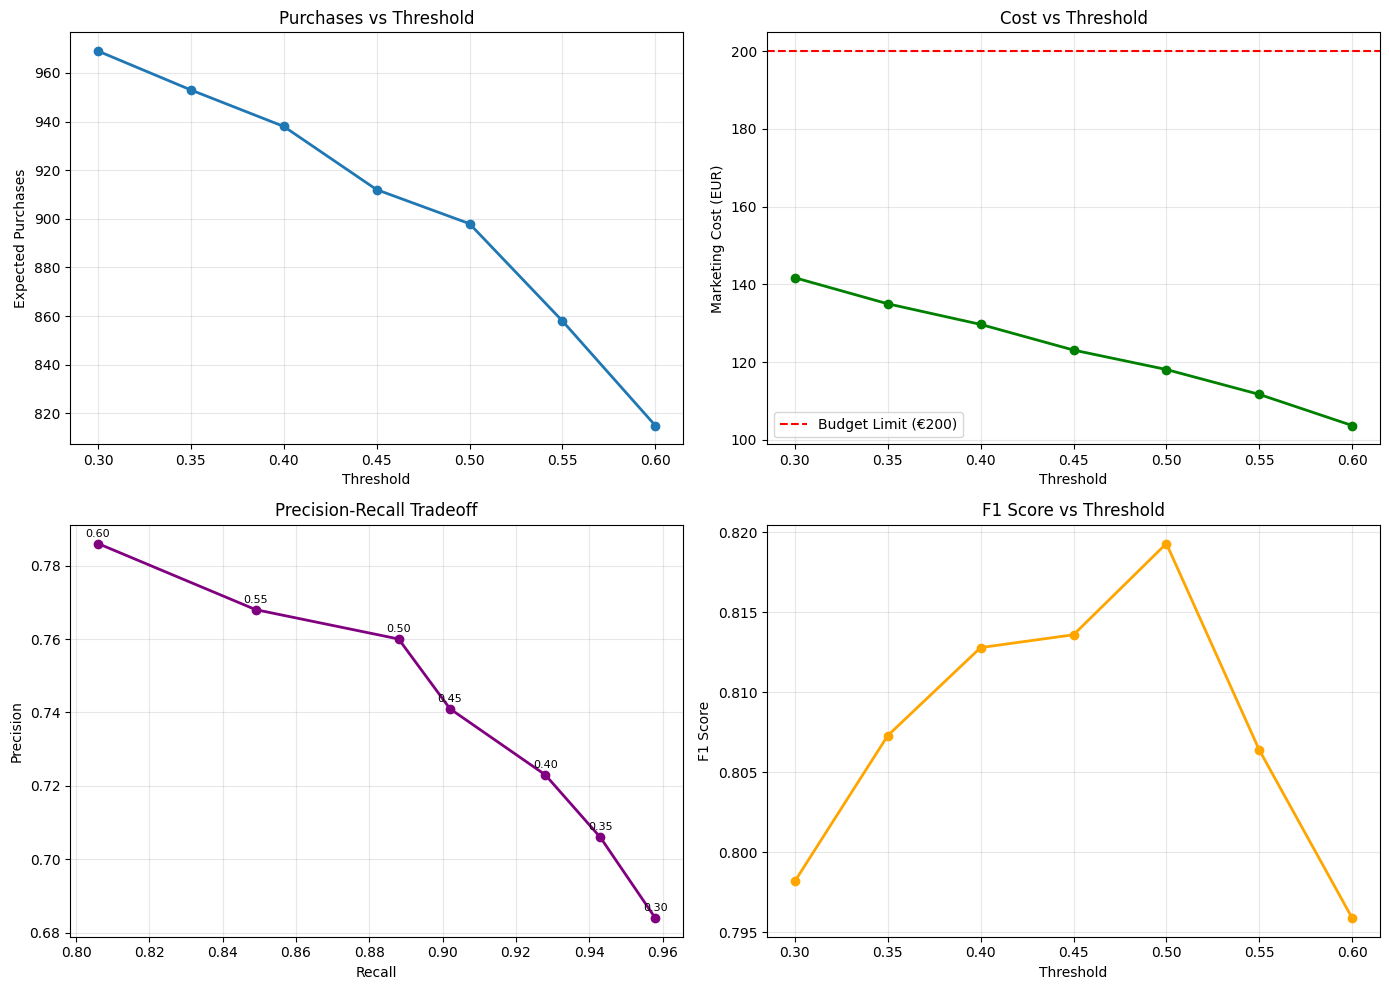

In [26]:
print("\n" + "="*70)
print("BUDGET OPTIMIZATION ANALYSIS (CORRECTED)")
print("="*70)

budget_analysis = []

for thresh in [0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60]:
    y_pred_temp = (y_pred_proba_best >= thresh).astype(int)
    
    # Recalculate confusion matrix for THIS threshold
    cm_temp = confusion_matrix(y_test, y_pred_temp)
    
    # Extract values
    tn = cm_temp[0, 0]
    fp = cm_temp[0, 1]
    fn = cm_temp[1, 0]
    tp = cm_temp[1, 1]
    
    # Metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = f1_score(y_test, y_pred_temp)
    
    # Business metrics
    n_targeted = y_pred_temp.sum()
    cost = n_targeted * 0.10
    expected_purchases = tp  # True positives
    
    # Revenue estimation (assume average order value)
    # Let's assume €50 average order value (adjust based on your data)
    avg_order_value = 50  # EUR
    expected_revenue = expected_purchases * avg_order_value
    roi = (expected_revenue - cost) / cost if cost > 0 else 0
    
    budget_analysis.append({
        'Threshold': thresh,
        'Users_Targeted': n_targeted,
        'Cost_EUR': f'{cost:.2f}',
        'Expected_Purchases': expected_purchases,
        'Expected_Revenue': f'{expected_revenue:.2f}',
        'ROI': f'{roi:.2f}',
        'Precision': f'{precision:.3f}',
        'Recall': f'{recall:.3f}',
        'F1_Score': f'{f1:.4f}'
    })

budget_df = pd.DataFrame(budget_analysis)
print("\n", budget_df.to_string(index=False))

# Find threshold that maximizes purchases within budget
print(f"\n📊 Budget Constraint: €200 (max 2000 users)")

# Convert back to numeric for analysis
budget_df['Users_Targeted_num'] = budget_df['Users_Targeted'].astype(int)
budget_df['Cost_EUR_num'] = budget_df['Cost_EUR'].astype(float)
budget_df['Expected_Purchases_num'] = budget_df['Expected_Purchases'].astype(int)
budget_df['Expected_Revenue_num'] = budget_df['Expected_Revenue'].astype(float)

under_budget = budget_df[budget_df['Cost_EUR_num'] <= 200]

if len(under_budget) > 0:
    # Strategy 1: Maximize purchases
    best_purchases = under_budget.iloc[under_budget['Expected_Purchases_num'].argmax()]
    
    # Strategy 2: Maximize ROI
    under_budget['ROI_num'] = under_budget['ROI'].astype(float)
    best_roi = under_budget.iloc[under_budget['ROI_num'].argmax()]
    
    print(f"\n🎯 STRATEGY 1: Maximize Total Purchases")
    print(f"  Threshold: {best_purchases['Threshold']}")
    print(f"  Target: {best_purchases['Users_Targeted']} users")
    print(f"  Cost: €{best_purchases['Cost_EUR']}")
    print(f"  Expected purchases: {best_purchases['Expected_Purchases']}")
    print(f"  Expected revenue: €{best_purchases['Expected_Revenue']}")
    print(f"  Precision: {best_purchases['Precision']}")
    print(f"  Recall: {best_purchases['Recall']}")
    
    print(f"\n💰 STRATEGY 2: Maximize ROI")
    print(f"  Threshold: {best_roi['Threshold']}")
    print(f"  Target: {best_roi['Users_Targeted']} users")
    print(f"  Cost: €{best_roi['Cost_EUR']}")
    print(f"  ROI: {best_roi['ROI']}x")
    print(f"  F1 Score: {best_roi['F1_Score']}")

# Visualize the tradeoff
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Purchases vs Threshold
axes[0, 0].plot(budget_df['Threshold'], budget_df['Expected_Purchases_num'], 'o-', linewidth=2)
axes[0, 0].set_xlabel('Threshold')
axes[0, 0].set_ylabel('Expected Purchases')
axes[0, 0].set_title('Purchases vs Threshold')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Cost vs Threshold
axes[0, 1].plot(budget_df['Threshold'], budget_df['Cost_EUR_num'], 'o-', linewidth=2, color='green')
axes[0, 1].axhline(y=200, color='red', linestyle='--', label='Budget Limit (€200)')
axes[0, 1].set_xlabel('Threshold')
axes[0, 1].set_ylabel('Marketing Cost (EUR)')
axes[0, 1].set_title('Cost vs Threshold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Precision vs Recall
precision_vals = [float(p) for p in budget_df['Precision']]
recall_vals = [float(r) for r in budget_df['Recall']]
axes[1, 0].plot(recall_vals, precision_vals, 'o-', linewidth=2, color='purple')
for i, thresh in enumerate(budget_df['Threshold']):
    axes[1, 0].annotate(f'{thresh:.2f}', (recall_vals[i], precision_vals[i]), 
                        textcoords="offset points", xytext=(0,5), ha='center', fontsize=8)
axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Precision-Recall Tradeoff')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: F1 Score vs Threshold
f1_vals = [float(f) for f in budget_df['F1_Score']]
axes[1, 1].plot(budget_df['Threshold'], f1_vals, 'o-', linewidth=2, color='orange')
axes[1, 1].set_xlabel('Threshold')
axes[1, 1].set_ylabel('F1 Score')
axes[1, 1].set_title('F1 Score vs Threshold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('budget_optimization_analysis.png', dpi=300, bbox_inches='tight')
print("\n✅ Saved visualization: budget_optimization_analysis.png")
plt.show()

In [27]:
# Test even lower thresholds
print("\n" + "="*70)
print("EXTENDED BUDGET ANALYSIS (LOWER THRESHOLDS)")
print("="*70)

extended_analysis = []

for thresh in [0.20, 0.25, 0.30, 0.35, 0.40]:
    y_pred_temp = (y_pred_proba_best >= thresh).astype(int)
    cm_temp = confusion_matrix(y_test, y_pred_temp)
    
    tn, fp, fn, tp = cm_temp[0, 0], cm_temp[0, 1], cm_temp[1, 0], cm_temp[1, 1]
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = f1_score(y_test, y_pred_temp)
    
    n_targeted = y_pred_temp.sum()
    cost = n_targeted * 0.10
    expected_purchases = tp
    avg_order_value = 50
    expected_revenue = expected_purchases * avg_order_value
    profit = expected_revenue - cost
    
    extended_analysis.append({
        'Threshold': thresh,
        'Users': n_targeted,
        'Cost': f'{cost:.2f}',
        'Purchases': expected_purchases,
        'Revenue': f'{expected_revenue:.0f}',
        'Profit': f'{profit:.0f}',
        'Precision': f'{precision:.3f}',
        'Recall': f'{recall:.3f}',
        'F1': f'{f1:.4f}'
    })

extended_df = pd.DataFrame(extended_analysis)
print("\n", extended_df.to_string(index=False))

# Find optimal within budget
extended_df['Cost_num'] = extended_df['Cost'].astype(float)
extended_df['Profit_num'] = extended_df['Profit'].astype(float)
within_budget = extended_df[extended_df['Cost_num'] <= 200]

if len(within_budget) > 0:
    optimal = within_budget.iloc[within_budget['Profit_num'].argmax()]
    print(f"\n💰 OPTIMAL STRATEGY (Max Profit within €200):")
    print(f"   Threshold: {optimal['Threshold']}")
    print(f"   Target: {optimal['Users']} users")
    print(f"   Cost: €{optimal['Cost']}")
    print(f"   Revenue: €{optimal['Revenue']}")
    print(f"   PROFIT: €{optimal['Profit']}")
    print(f"   Precision: {optimal['Precision']} | Recall: {optimal['Recall']}")


EXTENDED BUDGET ANALYSIS (LOWER THRESHOLDS)

  Threshold  Users   Cost  Purchases Revenue Profit Precision Recall     F1
      0.20   1566 156.60        984   49200  49043     0.628  0.973 0.7637
      0.25   1480 148.00        980   49000  48852     0.662  0.969 0.7868
      0.30   1417 141.70        969   48450  48308     0.684  0.958 0.7982
      0.35   1350 135.00        953   47650  47515     0.706  0.943 0.8073
      0.40   1297 129.70        938   46900  46770     0.723  0.928 0.8128

💰 OPTIMAL STRATEGY (Max Profit within €200):
   Threshold: 0.2
   Target: 1566 users
   Cost: €156.60
   Revenue: €49200
   PROFIT: €49043
   Precision: 0.628 | Recall: 0.973


In [28]:
import pandas as pd
import numpy as np

print("="*70)
print("GENERATING KAGGLE SUBMISSION")
print("="*70)

# Load the test dataset (without Purchase column)
test_data = pd.read_csv('/Users/jakobbullinger/Documents/Coding Projects/DSBA/Intro Machine Learning/kaggle_competition/data/raw/test_dataset_M1_with_id.csv')  # Adjust filename if needed

print(f"Test dataset shape: {test_data.shape}")
print(f"Test dataset columns: {test_data.columns.tolist()}")

# Check if 'id' column exists
if 'id' not in test_data.columns:
    print("⚠️ Warning: 'id' column not found!")
else:
    print(f"✅ Found {len(test_data)} sessions to predict")

# We need to apply the SAME preprocessing that Paul did
# For now, let's check what we need to do
print(f"\nColumns in training data: {X_clean.shape[1]}")
print(f"Columns in test data: {test_data.shape[1]}")

GENERATING KAGGLE SUBMISSION
Test dataset shape: (6265, 21)
Test dataset columns: ['id', 'Age', 'Gender', 'Reviews_Read', 'Price', 'Discount', 'Category', 'Items_In_Cart', 'Time_of_Day', 'Email_Interaction', 'Device_Type', 'Payment_Method', 'Referral_Source', 'Socioeconomic_Status_Score', 'Engagement_Score', 'AB_Bucket', 'Price_Sine', 'PM_RS_Combo', 'Session_ID', 'Day', 'Campaign_Period']
✅ Found 6265 sessions to predict

Columns in training data: 49
Columns in test data: 21


In [30]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

print("="*70)
print("PREPROCESSING TEST DATA (REPLICATING PAUL'S PIPELINE)")
print("="*70)

# Load test data
test_df = pd.read_csv('/Users/jakobbullinger/Documents/Coding Projects/DSBA/Intro Machine Learning/kaggle_competition/data/raw/test_dataset_M1_with_id.csv')
print(f"Original test shape: {test_df.shape}")

# ============================================================================
# STEP 1: CLEAN CATEGORICAL VARIABLES (Same as Paul did)
# ============================================================================

print("\nStep 1: Cleaning categorical variables...")

# Time_of_Day cleaning
if 'Time_of_Day' in test_df.columns:
    test_df['Time_of_Day'] = test_df['Time_of_Day'].replace({
        'afterno0n': 'afternoon',
        'aftern0on': 'afternoon', 
        'afTern00n': 'afternoon',
        'afteRno0n': 'afternoon',
        'm0rning': 'morning',
        'M0rning': 'morning'
    })

# Payment_Method cleaning
if 'Payment_Method' in test_df.columns:
    test_df['Payment_Method'] = test_df['Payment_Method'].replace({
        'bank_transfer': 'bank',
        'pay pal': 'paypal',
        'pay_pal': 'paypal'
    })
    # Make lowercase for consistency
    test_df['Payment_Method'] = test_df['Payment_Method'].str.lower()

# Referral_Source cleaning
if 'Referral_Source' in test_df.columns:
    test_df['Referral_Source'] = test_df['Referral_Source'].replace({
        'S0cial_meDia': 'social_media',
        'Search-Engine': 'search_engine'
    })
    # Make lowercase for consistency
    test_df['Referral_Source'] = test_df['Referral_Source'].str.lower()

# Campaign_Period handling
if 'Campaign_Period' in test_df.columns:
    test_df['Campaign_Period'] = test_df['Campaign_Period'].fillna(False).astype(int)

print("✅ Categorical cleaning complete")

# ============================================================================
# STEP 2: HANDLE MISSING VALUES (Same as Paul did)
# ============================================================================

print("\nStep 2: Handling missing values...")

# Check for missing values
print(f"Missing values before imputation:")
print(test_df.isnull().sum()[test_df.isnull().sum() > 0])

# Numerical features to impute (based on Paul's approach)
numerical_features = ['Age', 'Reviews_Read', 'Price', 'Discount', 'Items_In_Cart', 
                      'Socioeconomic_Status_Score', 'Engagement_Score', 'Day']

# Apply same imputation strategy Paul used
# Note: We should use the imputation values FROM TRAINING DATA, not test data
# For now, let's use simple imputation (you may need to adjust based on Paul's exact method)

for col in numerical_features:
    if col in test_df.columns and test_df[col].isnull().any():
        if col in ['Reviews_Read', 'Items_In_Cart', 'Discount']:
            # Zero imputation for counts/discounts
            test_df[col] = test_df[col].fillna(0)
        else:
            # Median imputation (should use training median, but using test median as approximation)
            test_df[col] = test_df[col].fillna(test_df[col].median())

# Categorical features - fill with 'Unknown' or most common
categorical_features = ['Gender', 'Category', 'Time_of_Day', 'Email_Interaction', 
                       'Device_Type', 'Payment_Method', 'Referral_Source']

for col in categorical_features:
    if col in test_df.columns and test_df[col].isnull().any():
        test_df[col] = test_df[col].fillna('Unknown')

print("✅ Missing value imputation complete")
print(f"\nMissing values after imputation:")
remaining_missing = test_df.isnull().sum().sum()
print(f"Total missing: {remaining_missing}")

# ============================================================================
# STEP 3: ONE-HOT ENCODING (Same as Paul did)
# ============================================================================

print("\nStep 3: One-hot encoding categorical variables...")

# Identify categorical columns
categorical_cols = test_df.select_dtypes(include=['object']).columns.tolist()

# Remove id and Session_ID if present
categorical_cols = [col for col in categorical_cols if col not in ['id', 'Session_ID']]

print(f"Categorical columns to encode: {categorical_cols}")

# One-hot encode
test_df_encoded = pd.get_dummies(test_df, columns=categorical_cols, drop_first=False)

print(f"Shape after encoding: {test_df_encoded.shape}")

# ============================================================================
# STEP 4: ALIGN COLUMNS WITH TRAINING DATA
# ============================================================================

print("\nStep 4: Aligning columns with training data...")

# Get training columns (excluding target)
training_columns = X_clean.columns.tolist()

print(f"Training has {len(training_columns)} features")
print(f"Test has {len(test_df_encoded.columns)} columns")

# Create aligned test dataframe
X_test_kaggle = pd.DataFrame()

# Add columns that exist in training
for col in training_columns:
    if col in test_df_encoded.columns:
        X_test_kaggle[col] = test_df_encoded[col]
    else:
        # Column missing in test - add with zeros
        X_test_kaggle[col] = 0
        print(f"  ⚠️ Added missing column '{col}' with zeros")

# Check if test has extra columns (shouldn't be used)
extra_cols = [col for col in test_df_encoded.columns 
              if col not in training_columns + ['id', 'Session_ID']]
if extra_cols:
    print(f"  ℹ️ Test has {len(extra_cols)} extra columns (will be ignored)")

print(f"✅ Final aligned test shape: {X_test_kaggle.shape}")
print(f"✅ Matches training shape: {X_clean.shape}")

# Verify column order matches
X_test_kaggle = X_test_kaggle[training_columns]

print("\n" + "="*70)
print("PREPROCESSING COMPLETE - READY FOR PREDICTIONS")
print("="*70)
print(f"Test sessions: {len(X_test_kaggle)}")
print(f"Features: {X_test_kaggle.shape[1]}")
print(f"Ready to predict: ✅")

PREPROCESSING TEST DATA (REPLICATING PAUL'S PIPELINE)
Original test shape: (6265, 21)

Step 1: Cleaning categorical variables...
✅ Categorical cleaning complete

Step 2: Handling missing values...
Missing values before imputation:
Age                           913
Gender                        140
Reviews_Read                  109
Price                         289
Discount                      127
Category                      113
Items_In_Cart                 120
Time_of_Day                   121
Email_Interaction             136
Device_Type                   122
Payment_Method                948
Referral_Source               979
Socioeconomic_Status_Score    125
Engagement_Score              128
AB_Bucket                     131
Price_Sine                    116
PM_RS_Combo                   140
Session_ID                    120
Day                           400
dtype: int64
✅ Missing value imputation complete

Missing values after imputation:
Total missing: 507

Step 3: One-hot enco

/var/folders/zw/s4899s557wd3yl88tyql43dm0000gn/T/ipykernel_58543/2017356866.py:51: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_df['Campaign_Period'] = test_df['Campaign_Period'].fillna(False).astype(int)


In [31]:
print("\n" + "="*70)
print("GENERATING PREDICTIONS")
print("="*70)

# Use your best model (the regularized one that won)
y_pred_proba_kaggle = best_model.predict_proba(X_test_kaggle)[:, 1]

# Use optimal threshold from validation (0.50)
optimal_threshold = 0.50
y_pred_kaggle = (y_pred_proba_kaggle >= optimal_threshold).astype(int)

print(f"\nPrediction distribution:")
print(f"  Predicted Purchase = 1: {y_pred_kaggle.sum()} ({y_pred_kaggle.mean()*100:.1f}%)")
print(f"  Predicted Purchase = 0: {(1-y_pred_kaggle).sum()} ({(1-y_pred_kaggle.mean())*100:.1f}%)")

# Sanity check: Should be roughly similar to training distribution (36.8% positive)
print(f"\nSanity check:")
print(f"  Training positive rate: 36.8%")
print(f"  Test predicted positive rate: {y_pred_kaggle.mean()*100:.1f}%")
if abs(y_pred_kaggle.mean() - 0.368) > 0.1:
    print("  ⚠️ Warning: Prediction distribution very different from training!")
else:
    print("  ✅ Prediction distribution looks reasonable")

# ============================================================================
# CREATE SUBMISSION FILE
# ============================================================================

print("\n" + "="*70)
print("CREATING SUBMISSION FILE")
print("="*70)

# Create submission dataframe
submission = pd.DataFrame({
    'id': test_df['id'],
    'Purchase': y_pred_kaggle
})

# Check for required format
print(f"\nSubmission file preview:")
print(submission.head(10))
print(f"\nSubmission shape: {submission.shape}")
print(f"Columns: {submission.columns.tolist()}")

# Save submission
submission.to_csv('kaggle_submission.csv', index=False)
print(f"\n✅ Saved: kaggle_submission.csv")
print(f"✅ Ready to submit to Kaggle!")

# Also save probabilities for analysis
submission_with_proba = pd.DataFrame({
    'id': test_df['id'],
    'Purchase': y_pred_kaggle,
    'Probability': y_pred_proba_kaggle
})
submission_with_proba.to_csv('kaggle_submission_with_probabilities.csv', index=False)
print(f"✅ Saved: kaggle_submission_with_probabilities.csv (for your reference)")


GENERATING PREDICTIONS

Prediction distribution:
  Predicted Purchase = 1: 3250 (51.9%)
  Predicted Purchase = 0: 3015 (48.1%)

Sanity check:
  Training positive rate: 36.8%
  Test predicted positive rate: 51.9%
  ⚠️ Warning: Prediction distribution very different from training!

CREATING SUBMISSION FILE

Submission file preview:
   id  Purchase
0   1         0
1   2         1
2   3         0
3   4         1
4   5         1
5   6         1
6   7         1
7   8         1
8   9         1
9  10         1

Submission shape: (6265, 2)
Columns: ['id', 'Purchase']

✅ Saved: kaggle_submission.csv
✅ Ready to submit to Kaggle!
✅ Saved: kaggle_submission_with_probabilities.csv (for your reference)
